# Structure discovery using a DFT surrogate model

In [1]:
# Installation - restart the kernel after running this cell
# !pip install camd[m3gnet,proto_dft]

In [2]:
# Several warnings from m3gnet, pyspglib are not relevant for this
# hide them for clarity
import warnings
warnings.filterwarnings('ignore')

In this notebook we demonstrate the basics of the structure discovery algorithms in CAMD. In lieu of actually doing DFT, which is expensive, we use an alternate model that is not as accurate but very cheap. The surrogate model we use is a ML-potential model called [m3gnet](https://github.com/materialsvirtuallab/m3gnet), which can both provide us with energies and optimize our structures. Note that structure discovery campaign results from m3gnet should be interpreted very conservatively, and that a large database of results from m3gnet can already be found at [matterverse.ai](http://matterverse.ai).

In [3]:
# Copyright Toyota Research Institute 2022
from camd.campaigns.base import Campaign
from sklearn.neural_network import MLPRegressor
from camd.agent.stability import AgentStabilityAdaBoost
from camd.analysis import StabilityAnalyzer
from camd.experiment.base import Experiment
from camd.experiment.dft import get_mp_formation_energy_from_m3gnet
from camd.utils.data import load_default_atf_data
import pandas as pd
import os
import re
import shutil
from m3gnet.models import M3GNet, Potential, Relaxer
from pymatgen.io.ase import AseAtomsAdaptor
from tqdm import tqdm

Load dataset - this default dataset contains all of the OQMD binary compounds, including Composition (or reduced_formula), delta_e (formation_energy_per_atom), and features computed according to Ward et al. (2017).

In [4]:
# We'll be using a cached dataset, but here's an example of how you
# can fetch data from the materials project if needed
use_cached = True
if not use_cached:
    from pymatgen.ext.matproj import MPRester
    from camd.utils.data import get_default_featurizer
    with MPRester() as mpr:
        binary_sulfides = mpr.query({"nelements": 2, "elements": "S"}, 
                 ['structure', 'material_id', 
                  'pretty_formula', 'formation_energy_per_atom'])
        unary_materials = mpr.query({"nelements": 1, "e_above_hull": 0}, 
                 ['structure', 'material_id', 
                  'pretty_formula', 'formation_energy_per_atom'])
    data = binary_sulfides + unary_materials # concatenate two datasets
    data = {r['material_id']: r for r in data}
    dataframe = pd.DataFrame.from_dict(data, orient='index')
    featurizer = get_default_featurizer()
    dataframe = featurizer.featurize_dataframe(dataframe, 'structure', ignore_errors=True)
    dataframe = dataframe.rename(columns={
         "formation_energy_per_atom": "delta_e",
         "pretty_formula": "Composition"
    })
    dataframe = dataframe.dropna()
    dataframe = dataframe.drop_duplicates(subset='material_id')
    dataframe.to_pickle("binary_sulfides_mp.pickle")
    seed_data = dataframe
else:
    # Use the cached dataset
    seed_data = pd.read_pickle("binary_sulfides_mp.pickle")
    seed_data = seed_data.dropna()

In [5]:
# CAMD generates structure using a structure generation algorithm 
# defined by Wyckoff-site enumerated prototypes, we'll also cache
# these because featurization takes a little while, but here's the code
use_cached = True
if not use_cached:
    from camd.domain import StructureDomain, heuristic_setup
    chemsys = ["Mn", "S"]
    max_coeff, charge_balanced = heuristic_setup(chemsys)
    domain = StructureDomain.from_bounds(
        chemsys,
        charge_balanced=charge_balanced,
        n_max_atoms=20,
        grid=(1, max_coeff)
    )
    candidate_data = domain.candidates()
    candidate_data.to_pickle("mn_s_candidates.pickle")
else:
    candidate_data = pd.read_pickle("mn_s_candidates.pickle")

In [6]:
class MockVasprun():
    """
    This is a hacked version of the Vasprun object
    that makes the experiment compatible with the
    final analyzer in CAMD
    """
    final_structure = None
    final_energy = None

In [7]:
# Define the experiment
# Experiment classes in CAMD require 3 methods
# - submit starts the calculation
# - get_results returns a dataframe with results
# - monitor is a method to wait until results are done, which ensures 
#   compatibility with CAMD logic
class M3GNetExperiment(Experiment):
    def submit(self, data):
        """data is a pandas dataframe that must have a column called structure"""
        # Sometimes in this method you might submit to an external system,
        # e.g. AWS batch or a supercomputer, but in this case we just update
        # the data because we do the computation locally
        self.update_current_data(data)
        
    def monitor(self):
        relaxer = Relaxer()
        delta_es = []
        status = []
        results = []
        for index, row in tqdm(self.current_data.iterrows(), desc="Experiments"):
            s = row['structure']
            t = relaxer.relax(s)["trajectory"]
            e = t.energies[-1].flatten()[0]
            delta_e = get_mp_formation_energy_from_m3gnet(
                e, s
            )
            result = MockVasprun()
            result.final_structure = row['structure']
            result.final_energy = e
            delta_es.append(delta_e)
            status.append('SUCCEEDED')
            results.append(result)
        self.current_data['delta_e'] = delta_es
        self.current_data['status'] = status
        self.current_data['result'] = results
        # This is a hack to ensure compatibility with the final analysis
        # which uses Vasprun objects
        
    
    def get_results(self):
        return self.current_data

In [8]:
from pymatgen.ext.matproj import MPRester
with MPRester() as mpr:
    structure = mpr.get_structure_by_material_id("mp-66")
relaxer = Relaxer()
t = relaxer.relax(structure)['trajectory']

In [9]:
t.atoms

Atoms(symbols='C2', pbc=True, cell=[[0.0, 1.786855, 1.786855], [1.786855, 0.0, 1.786855], [1.786855, 1.786855, 0.0]], initial_magmoms=..., calculator=M3GNetCalculator(...))

In [10]:
# Let's test the experiment
experiment = M3GNetExperiment()
experiment.submit(candidate_data.sample(3))
experiment.monitor()
results = experiment.get_results()

Experiments: 3it [00:15,  5.23s/it]


In [11]:
results[['delta_e']]

,delta_e
51-S-e-Mn-f,-0.754006
223-S-c-Mn-d,-0.796201
12-S-g-S-g-S-j-Mn-i-Mn-i-Mn-j,-0.657904


In [12]:
##########################################################
# Binary stable material discovery 50:50 explore/exploit agent
##########################################################
n_query = 5  # This many new candidates are "calculated with DFT" 
# (i.e. requested from Oracle -- DFT)
agent = AgentStabilityAdaBoost(
    model=MLPRegressor(hidden_layer_sizes=(40, 20)),
    n_query=n_query,
    hull_distance=0.05,
    uncertainty=True,
    exploit_fraction=0.8, # Number of candidates chosen by the ML model, rest are random
    alpha=0.5, # Weighting of the estimated uncertainty from the AdaBoost ensemble
    n_estimators=10
)
analyzer = StabilityAnalyzer(hull_distance=0.05)
experiment = M3GNetExperiment()

In [13]:
# Usually takes ~5-10 minutes
path = os.path.join(os.getcwd(), "m3gnet_structure_discovery")
shutil.rmtree(path, ignore_errors=True)
os.makedirs(path)
campaign = Campaign(
    candidate_data, 
    agent, 
    experiment, 
    analyzer, 
    seed_data=seed_data,
    path=path
)
campaign.auto_loop(n_iterations=2, initialize=True)

Campaign initialization state: Agent AgentStabilityAdaBoost hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Experiments: 3it [00:21,  7.06s/it]
Campaign 0 state: Analyzing results
Campaign 0 state: Agent AgentStabilityAdaBoost hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Experiments: 2it [00:11,  5.57s/it]
Campaign 1 state: Analyzing results
Campaign 1 state: Agent AgentStabilityAdaBoost hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Experiments: 4it [05:13, 78.25s/it] 
Campaign 2 state: Analyzing results
Campaign 2 state: Agent AgentStabilityAdaBoost hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Finalizing campaign.


In [14]:
campaign.history

,new_candidates,new_discovery,total_discovery
0,3,1,1
1,2,0,1
2,4,0,1


<AxesSubplot:>

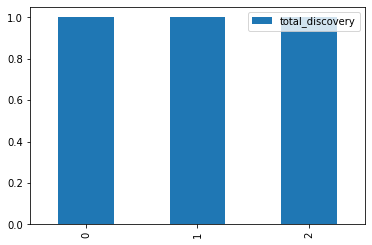

In [15]:
campaign.history.plot.bar(y='total_discovery')

![hull.png](m3gnet_structure_discovery/hull.png)

In [20]:
# To fetch the seed_data.
campaign.analyzer[0].current_analysis

,stability,is_stable
2-Mn-i-S-i-S-i-S-i-S-i-S-i-S-i-S-i-S-i,0.000000,True
mp-77,0.001007,True
164-Mn-c-Mn-d-Mn-d-S-c-S-d-S-d,0.166483,False
mp-608100,0.440143,False
mp-655141,0.357319,False
194-S-e-Mn-f,0.242535,False
mp-1063988,1.137487,False
mp-556853,0.501455,False
164-S-c-S-d-S-d-Mn-c-Mn-d-Mn-d,0.166057,False
mp-1455,0.203513,False


In the real CAMD campaign, the agent is a little stronger, having access to both the entire ICSD dataset from the OQMD for regression and using more estimators to get a stronger prediction and uncertainty estimate. Similarly, in the real ProtoDFTCampaign, one can invoke from a chemical system, and logging and storage are backed up to the cloud. Lastly, the production ProtoDFTCampaign uses a custom DFT submission backend that runs OQMD-parametrized DFT simulations using AWS Batch.